In [1]:
#pip install pennylane

In [1]:
import pennylane as qml
from pennylane import numpy as np
np.random.seed(0)

import flatnetwork_simple as fns

# REAL S&P 500 DATASET

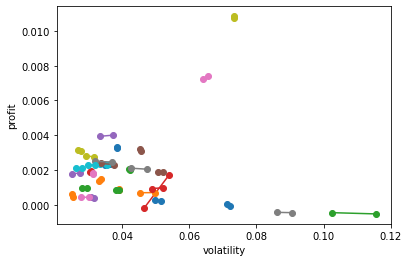

In [2]:
from dataloader_class import *
dl = data_loader('data/covid2020.csv')
dl.split_windows(180)
dl.plot_trajectories()

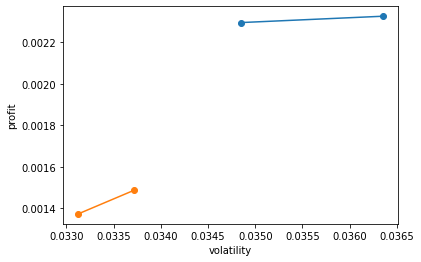

In [3]:
dl.filter_assets(num_assets=2, method='relevant')
dl.plot_trajectories()

In [4]:
mut = dl.return_mut()
sigmat = dl.return_sigmat()
print(mut.shape)

(2, 2)


# DMRG SOLUTION

In [5]:
L = [mut.shape[0],mut.shape[1],2]
d = 2

#Parameters
mu = lambda t,i: mut[t,i]
rho = 5.0

fnet = fns.FlatNetwork(L,d)
fnet.loadParams(mu, rho)
fnet.make_mpos()

S, D = fnet.getHamiltonian()

Max MPO dim:  9


In [6]:
sweepD = [     1,     2,     2,     3,     3,     4,     5,     8,    10]
sweepI = [    10,    10,    10,    10,    10,    10,    10,    10,    10]
sweepN = [1.0e-2,1.0e-3,1.0e-4,1.0e-5,1.0e-6,1.0e-6,1.0e-6,1.0e-6,1.0e-6]
sweepM = [     5,     5,     5,     5,     5,     5,     5,     5,     5]

cc = 5
e, mps = fnet.run(sweepd = sweepD[:cc], sweepi = sweepI[:cc], sweepn = sweepN[:cc], sweepmin = sweepM[:cc])

Schedule:  0  D =  1
Beginning sweep:  0 of 10
Sweep Energy: -1.87945522
Beginning sweep:  1 of 10
Sweep Energy: -1.87945522
Beginning sweep:  2 of 10
Sweep Energy: -1.87945522
Beginning sweep:  3 of 10
Sweep Energy: -1.87945522
Beginning sweep:  4 of 10
Sweep Energy: -1.87945522
Beginning sweep:  5 of 10
Sweep Energy: -1.87945522
-----------
Schedule:  1  D =  2
Beginning sweep:  0 of 10
Sweep Energy: -1.87945522
Beginning sweep:  1 of 10
Sweep Energy: -1.87945522
Beginning sweep:  2 of 10
Sweep Energy: -2.17874469
Beginning sweep:  3 of 10
Sweep Energy: -2.19184230
Beginning sweep:  4 of 10
Sweep Energy: -2.19184230
Beginning sweep:  5 of 10
Sweep Energy: -2.19184230
-----------
Schedule:  2  D =  2
Beginning sweep:  0 of 10
Sweep Energy: -2.19184230
Beginning sweep:  1 of 10
Sweep Energy: -2.19184230
Beginning sweep:  2 of 10
Sweep Energy: -2.19184230
Beginning sweep:  3 of 10
Sweep Energy: -2.19184230
Beginning sweep:  4 of 10
Sweep Energy: -2.19184230
Beginning sweep:  5 of 10
Swe

In [7]:
fvs = fnet.computeWeights(mps)
fvm = np.zeros([L[1],L[0]])

for pair in fvs:
    fvm[pair[1],pair[0]] = fvs[pair]
    if(abs(fvs[pair]>1.0e-8)):
        print(pair, fvs[pair], mu(pair[0],pair[1]))

(0, 0) 0.7500000000000023 0.0023250259995950874
(0, 1) 0.25000000000000255 0.0014874160104551906
(1, 0) 0.7500000000000023 0.0022945917350109314
(1, 1) 0.2500000000000012 0.001373131611521413


Text(0, 0.5, 'Weight')

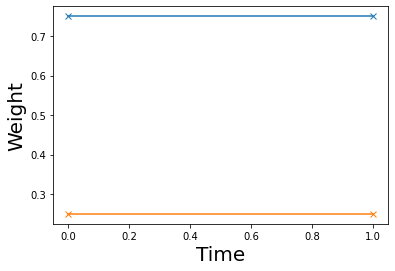

In [8]:
import matplotlib.pyplot as plt

ts = [t for t in range(0,L[0])]

for i in range(L[1]):
    plt.plot(ts,fvm[i,:],'-x')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Weight', fontsize=20)

Text(0, 0.5, 'Relative Profit')

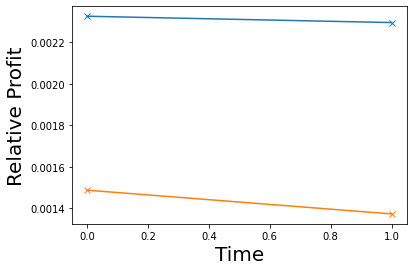

In [9]:
for i in range(L[1]):
    plt.plot(ts,mut[:,i],'-x')
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Relative Profit', fontsize=20)

# QAOA

In [10]:
#Must convert all parameters to pauli basis

Snew = {}
for pair in S:
    Snew[pair[0]] = -S[pair]/2 if not pair[0] in Snew else Snew[pair[0]] - S[pair]/2

for pair in D:
    if(pair[0]==pair[1]): #n^2 term
        Snew[pair[0]] = -D[pair]/2 if not pair[0] in Snew else Snew[pair[0]] -D[pair]/2
    else:
        Snew[pair[0]] = -D[pair]/2 if not pair[0] in Snew else Snew[pair[0]] -D[pair]/2
        Snew[pair[0]] = -D[pair]/2 if not pair[1] in Snew else Snew[pair[1]] -D[pair]/2

S2new = {}
for pair in D:
    if(pair[0]==pair[1]): #n^2 term
        S2new[pair[0]] = -D[pair]/4 if not pair[0] in S2new else S2new[pair[0]] - D[pair]/4

Dnew = {}
for pair in D:
    if(pair[0]!=pair[1]): #n_a n_b term
        Dnew[pair] = D[pair]/4 if not pair in Dnew else Dnew[pair[0]] + D[pair]/4
        
print(S)
print(D)
print('\n')
print(Snew)
print(S2new)
print(Dnew)


{(0, 0): -2.5005812564998986, (1, 1): -5.001162512999797, (2, 2): -2.500371854002614, (3, 3): -5.000743708005228, (4, 4): -2.5005736479337526, (5, 5): -5.001147295867505, (6, 6): -2.50034328290288, (7, 7): -5.00068656580576}
{(0, 0): 0.3125, (0, 1): 1.25, (0, 3): 2.5, (0, 2): 0.625, (1, 1): 1.25, (1, 3): 2.5, (2, 2): 0.3125, (2, 3): 1.25, (3, 3): 1.25, (4, 4): 0.3125, (4, 5): 1.25, (4, 7): 2.5, (4, 6): 0.625, (5, 5): 1.25, (5, 7): 2.5, (6, 6): 0.3125, (6, 7): 1.25, (7, 7): 1.25}


{0: 0.9376859270013069, 1: 1.2503718540026139, 2: 1.8753718540026139, 3: 1.8753718540026139, 4: 0.9376716414514401, 5: 1.2503432829028802, 6: 1.8753432829028802, 7: 1.8753432829028802}
{0: -0.078125, 1: -0.3125, 2: -0.078125, 3: -0.3125, 4: -0.078125, 5: -0.3125, 6: -0.078125, 7: -0.3125}
{(0, 1): 0.3125, (0, 3): 0.625, (0, 2): 0.15625, (1, 3): 0.625, (2, 3): 0.3125, (4, 5): 0.3125, (4, 7): 0.625, (4, 6): 0.15625, (5, 7): 0.625, (6, 7): 0.3125}


In [11]:
n_wires = int(np.prod(L))

H = qml.Hamiltonian(
    [Snew[wire] for wire in Snew] + [S2new[wire] for wire in S2new] + [Dnew[wire] for wire in Dnew],
    [qml.PauliZ(wire) for wire in Snew] + [qml.Identity(wire) for wire in S2new] + [qml.PauliZ(wire[0])@qml.PauliZ(wire[1]) for wire in Dnew]
)

print(H)    

  (-0.3125) [I1]
+ (-0.3125) [I3]
+ (-0.3125) [I5]
+ (-0.3125) [I7]
+ (-0.078125) [I0]
+ (-0.078125) [I2]
+ (-0.078125) [I4]
+ (-0.078125) [I6]
+ (0.9376716414514401) [Z4]
+ (0.9376859270013069) [Z0]
+ (1.2503432829028802) [Z5]
+ (1.2503718540026139) [Z1]
+ (1.8753432829028802) [Z6]
+ (1.8753432829028802) [Z7]
+ (1.8753718540026139) [Z2]
+ (1.8753718540026139) [Z3]
+ (0.15625) [Z0 Z2]
+ (0.15625) [Z4 Z6]
+ (0.3125) [Z0 Z1]
+ (0.3125) [Z2 Z3]
+ (0.3125) [Z4 Z5]
+ (0.3125) [Z6 Z7]
+ (0.625) [Z0 Z3]
+ (0.625) [Z1 Z3]
+ (0.625) [Z4 Z7]
+ (0.625) [Z5 Z7]


In [12]:
Hm = qml.Hamiltonian(
    [1.0 for wire in range(n_wires)],
    [qml.PauliX(wire) for wire in range(n_wires)]
)

print(Hm)

  (1.0) [X0]
+ (1.0) [X1]
+ (1.0) [X2]
+ (1.0) [X3]
+ (1.0) [X4]
+ (1.0) [X5]
+ (1.0) [X6]
+ (1.0) [X7]


In [13]:
from pennylane import qaoa

In [14]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, H)
    qaoa.mixer_layer(alpha, Hm)

In [15]:
depth = 2
wires = range(n_wires)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [16]:
dev = qml.device("qulacs.simulator", wires=wires)
cost_function = qml.ExpvalCost(circuit, H, dev)

In [19]:
optimizer = qml.GradientDescentOptimizer()
steps = 200
params = [[0.5,0.5], [0.5,0.5]]

In [20]:
for i in range(steps):
    params  = optimizer.step(cost_function, params)
    if (i+1)%5 == 0:
        print('Step {:5d}: {: .7f}'.format(i+1, cost_function(params)))

print("Optimal Parameters")
print(params)

Step     5: -5.8211704
Step    10: -6.0685687
Step    15: -6.0878808
Step    20: -6.0916436
Step    25: -6.0948448
Step    30: -6.0990229
Step    35: -6.1052570
Step    40: -6.1159141
Step    45: -6.1376206
Step    50: -6.1934446
Step    55: -6.3805907
Step    60: -6.9514192
Step    65: -7.5221705
Step    70: -7.7963381
Step    75: -8.0151973
Step    80: -8.2719204
Step    85: -8.5863497
Step    90: -8.9210239
Step    95: -9.1319927
Step   100: -9.2223219
Step   105: -9.2609239
Step   110: -9.2780827
Step   115: -9.2859186
Step   120: -9.2895644
Step   125: -9.2912831
Step   130: -9.2921009
Step   135: -9.2924927
Step   140: -9.2926812
Step   145: -9.2927723
Step   150: -9.2928163
Step   155: -9.2928377
Step   160: -9.2928481
Step   165: -9.2928531
Step   170: -9.2928555
Step   175: -9.2928567
Step   180: -9.2928573
Step   185: -9.2928576
Step   190: -9.2928577
Step   195: -9.2928578
Step   200: -9.2928578
Optimal Parameters
[[0.2024350224361913, 0.3753336669373794], [0.852065118732897

In [22]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma,alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

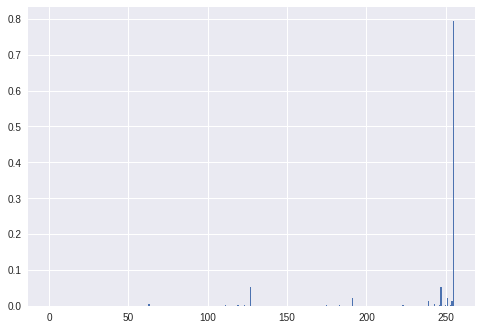

In [23]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.bar(range(2**len(wires)), probs)
plt.show()

In [24]:
print(np.argmax(probs))

255


In [72]:
#Most probabable State
sv = bin(np.argmax(probs))[2:].zfill(len(wires))
print(sv)

11111111


In [77]:
fvs = fnet.returnWeights(sv)
fvm = np.zeros([L[1],L[0]])

print(fvs)

for t in range(L[0]):
    for i in range(L[1]):        
        fvm[i,t] = fvs[t,i]
    if(abs(fvs[t,i]>1.0e-8)):
        print(t,i, fvs[t,i], mu(t,i))

[[0.75 0.75]
 [0.75 0.75]]
0 1 0.75 0.0014874160104551906
1 1 0.75 0.001373131611521413


Text(0, 0.5, 'Weight')

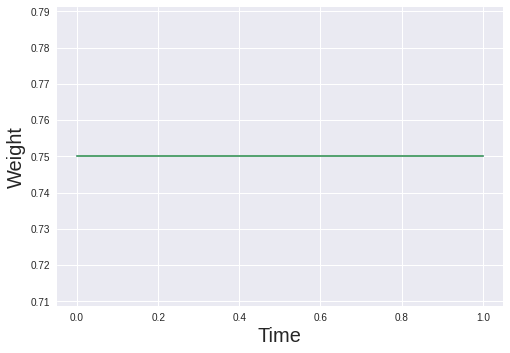

In [78]:
import matplotlib.pyplot as plt

ts = [t for t in range(0,L[0])]

for i in range(L[1]):
    plt.plot(ts,fvm[i,:],'-x')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Weight', fontsize=20)

Text(0, 0.5, 'Relative Profit')

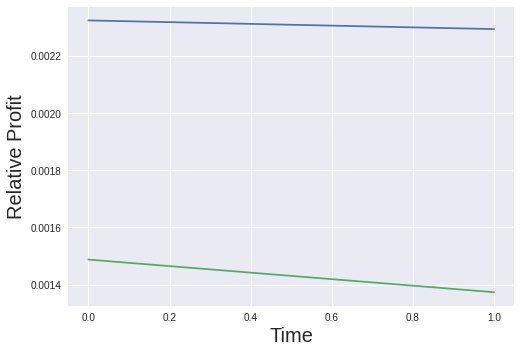

In [79]:
for i in range(L[1]):
    plt.plot(ts,mut[:,i],'-x')
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Relative Profit', fontsize=20)